# RDS HW3 Template

Install the Data Synthesizer library.

# Section

In [1]:
!pip install DataSynthesizer

In [2]:
from DataSynthesizer.DataDescriber import DataDescriber
from DataSynthesizer.DataGenerator import DataGenerator
from DataSynthesizer.ModelInspector import ModelInspector
from DataSynthesizer.lib.utils import normalize_given_distribution, read_json_file, pairwise_attributes_mutual_information, mutual_information, set_random_seed

from IPython.display import clear_output
from scipy.stats import entropy, ks_2samp
from scipy.spatial.distance import euclidean
from sklearn.metrics import mutual_info_score
from random import randint
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
def generate_data_A(input_data_file, output_data_size, seed=None):
    seed = seed or randint(0, 2**30)
    description_file = description_files['A']

    describer = DataDescriber()
    describer.describe_dataset_in_random_mode(input_data_file, seed=seed)
    describer.save_dataset_description_to_file(description_file)

    generator = DataGenerator()
    generator.generate_dataset_in_random_mode(output_data_size, description_file, seed=seed)
    return generator.synthetic_dataset

In [4]:
def generate_data_B(input_data_file, output_data_size, epsilon=0.1, seed=None):
    seed = seed or randint(0, 2**30)
    description_file = description_files['B']

    describer = DataDescriber()
    describer.describe_dataset_in_independent_attribute_mode(input_data_file, epsilon=epsilon, seed=seed)
    describer.save_dataset_description_to_file(description_file)

    generator = DataGenerator()
    generator.generate_dataset_in_independent_mode(output_data_size, description_file, seed=seed)
    return generator.synthetic_dataset

In [5]:
def generate_data_CD(input_data_file, output_data_size, description_file, epsilon=0.5, k=1, seed=None):
    seed = seed or randint(0, 2**30)

    describer = DataDescriber()
    describer.describe_dataset_in_correlated_attribute_mode(input_data_file, k=k, epsilon=epsilon, seed=seed)
    describer.save_dataset_description_to_file(description_file)

    generator = DataGenerator()
    generator.generate_dataset_in_correlated_attribute_mode(output_data_size, description_file, seed=seed)
    return generator.synthetic_dataset

def generate_data_C(input_data_file, output_data_size, epsilon=0.1, seed=None):
    return generate_data_CD(input_data_file, output_data_size, description_files['C'], epsilon, k=1, seed=seed)

def generate_data_D(input_data_file, output_data_size, epsilon=0.1, seed=None):
    return generate_data_CD(input_data_file, output_data_size, description_files['D'], epsilon, k=2, seed=seed)

Start with a real dataset __hw_compas__ and a fake dataset __hw_xyz__. Generate synthetic datasets of size __N=10000__, in the following four categories:
- A:  random mode
- B: independent attribute mode with __epsilon = 0.1__
- C:  correlated attribute mode with __epsilon = 0.1__, Bayes net degree k=1
- D: correlated attribute mode with __epsilon = 0.1__, Bayes net degree k=2

In [6]:
# Packages for reading csv file into Colaboratory:
!pip install -U -q PyDrive==1.3.1

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# Please follow the steps as instructed when you run the following commands.

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [7]:
fileid_compas = '1kgSIBkOM9y0nz_l8LI8ze9TAhF5gbb64'
real_data_file = 'hw_compas.csv'

fileid_fake = '1b_T0SHQUMbVvZueZ6yXlxTKBHctMgM0k'
fake_data_file = 'hw_fake.csv'

downloaded = drive.CreateFile({'id':fileid_compas})
downloaded.GetContentFile(real_data_file)
df_real = pd.read_csv(real_data_file)

downloaded = drive.CreateFile({'id':fileid_fake})
downloaded.GetContentFile(fake_data_file)
df_fake = pd.read_csv(fake_data_file)

In [8]:
output_data_size = 10000
epsilon = 0.1

seed = 0  # make the entire notebook reproducible

description_files = {'A': './descrption_A.json',
                     'B': './descrption_B.json',
                     'C': './descrption_C.json',
                     'D': './descrption_D.json'}

set_random_seed(seed)

df_real_A = generate_data_A(real_data_file, output_data_size)
df_real_B = generate_data_B(real_data_file, output_data_size, epsilon=epsilon)
df_real_C = generate_data_C(real_data_file, output_data_size, epsilon=epsilon)
df_real_D = generate_data_D(real_data_file, output_data_size, epsilon=epsilon)

df_fake_A = generate_data_A(fake_data_file, output_data_size)
df_fake_B = generate_data_B(fake_data_file, output_data_size, epsilon=epsilon)
df_fake_C = generate_data_C(fake_data_file, output_data_size, epsilon=epsilon)
df_fake_D = generate_data_D(fake_data_file, output_data_size, epsilon=epsilon)

clear_output()

## Part (a)

### Q1

Median, Mean, Min, Max of __age__ and __score__ for each A, B, C and D, compare to the ground truth value in __hw_compas__, present results in a table

In [193]:
def cal_statistics(df,attribute):
  return {
      "median":df[attribute].median(),
      "mean":df[attribute].mean(),
      "min":df[attribute].min(),
      "max":df[attribute].max()
  }

datasets = {
    "Real" : df_real,
    "A": df_real_A,
    "B": df_real_B,
    "C": df_real_C,
    "D": df_real_D
}
attributes = ["age","score"]

table = pd.DataFrame(columns=["Dataset","Median Age","Mean Age","Min Age","Max Age","Median Score","Mean Score","Min Score","Max Score"])
all_stat = []
for name,df in datasets.items():
  row = {"Dataset": name}
  for attr in attributes:
    stats = cal_statistics(df,attr)
    row[f"Median {attr.capitalize()}"] = stats["median"]
    row[f"Mean {attr.capitalize()}"] = stats["mean"]
    row[f"Min {attr.capitalize()}"] = stats["min"]
    row[f"Max {attr.capitalize()}"] = stats["max"]
  all_stat.append(row)

table = pd.DataFrame(all_stat)

table

,Dataset,Median Age,Mean Age,Min Age,Max Age,Median Score,Mean Score,Min Score,Max Score
0,Real,32.0,35.143319,18.0,96.0,4.0,4.371268,-1,10
1,A,51.0,50.173100,0.0,100.0,5.0,4.939200,-1,10
2,B,33.0,35.735400,18.0,76.0,4.0,4.365700,1,10
3,C,36.0,41.578800,18.0,96.0,5.0,4.948700,-1,10
4,D,39.0,44.153200,18.0,96.0,4.0,4.466000,-1,10


### Q2

Some more sophisticated statistical measure that’s good for independent attribute mode - __Two-sample Kolmogorov–Smirnov test__ and __KL-divergence__. Also show the difference visually, comparing real vs. synthetic

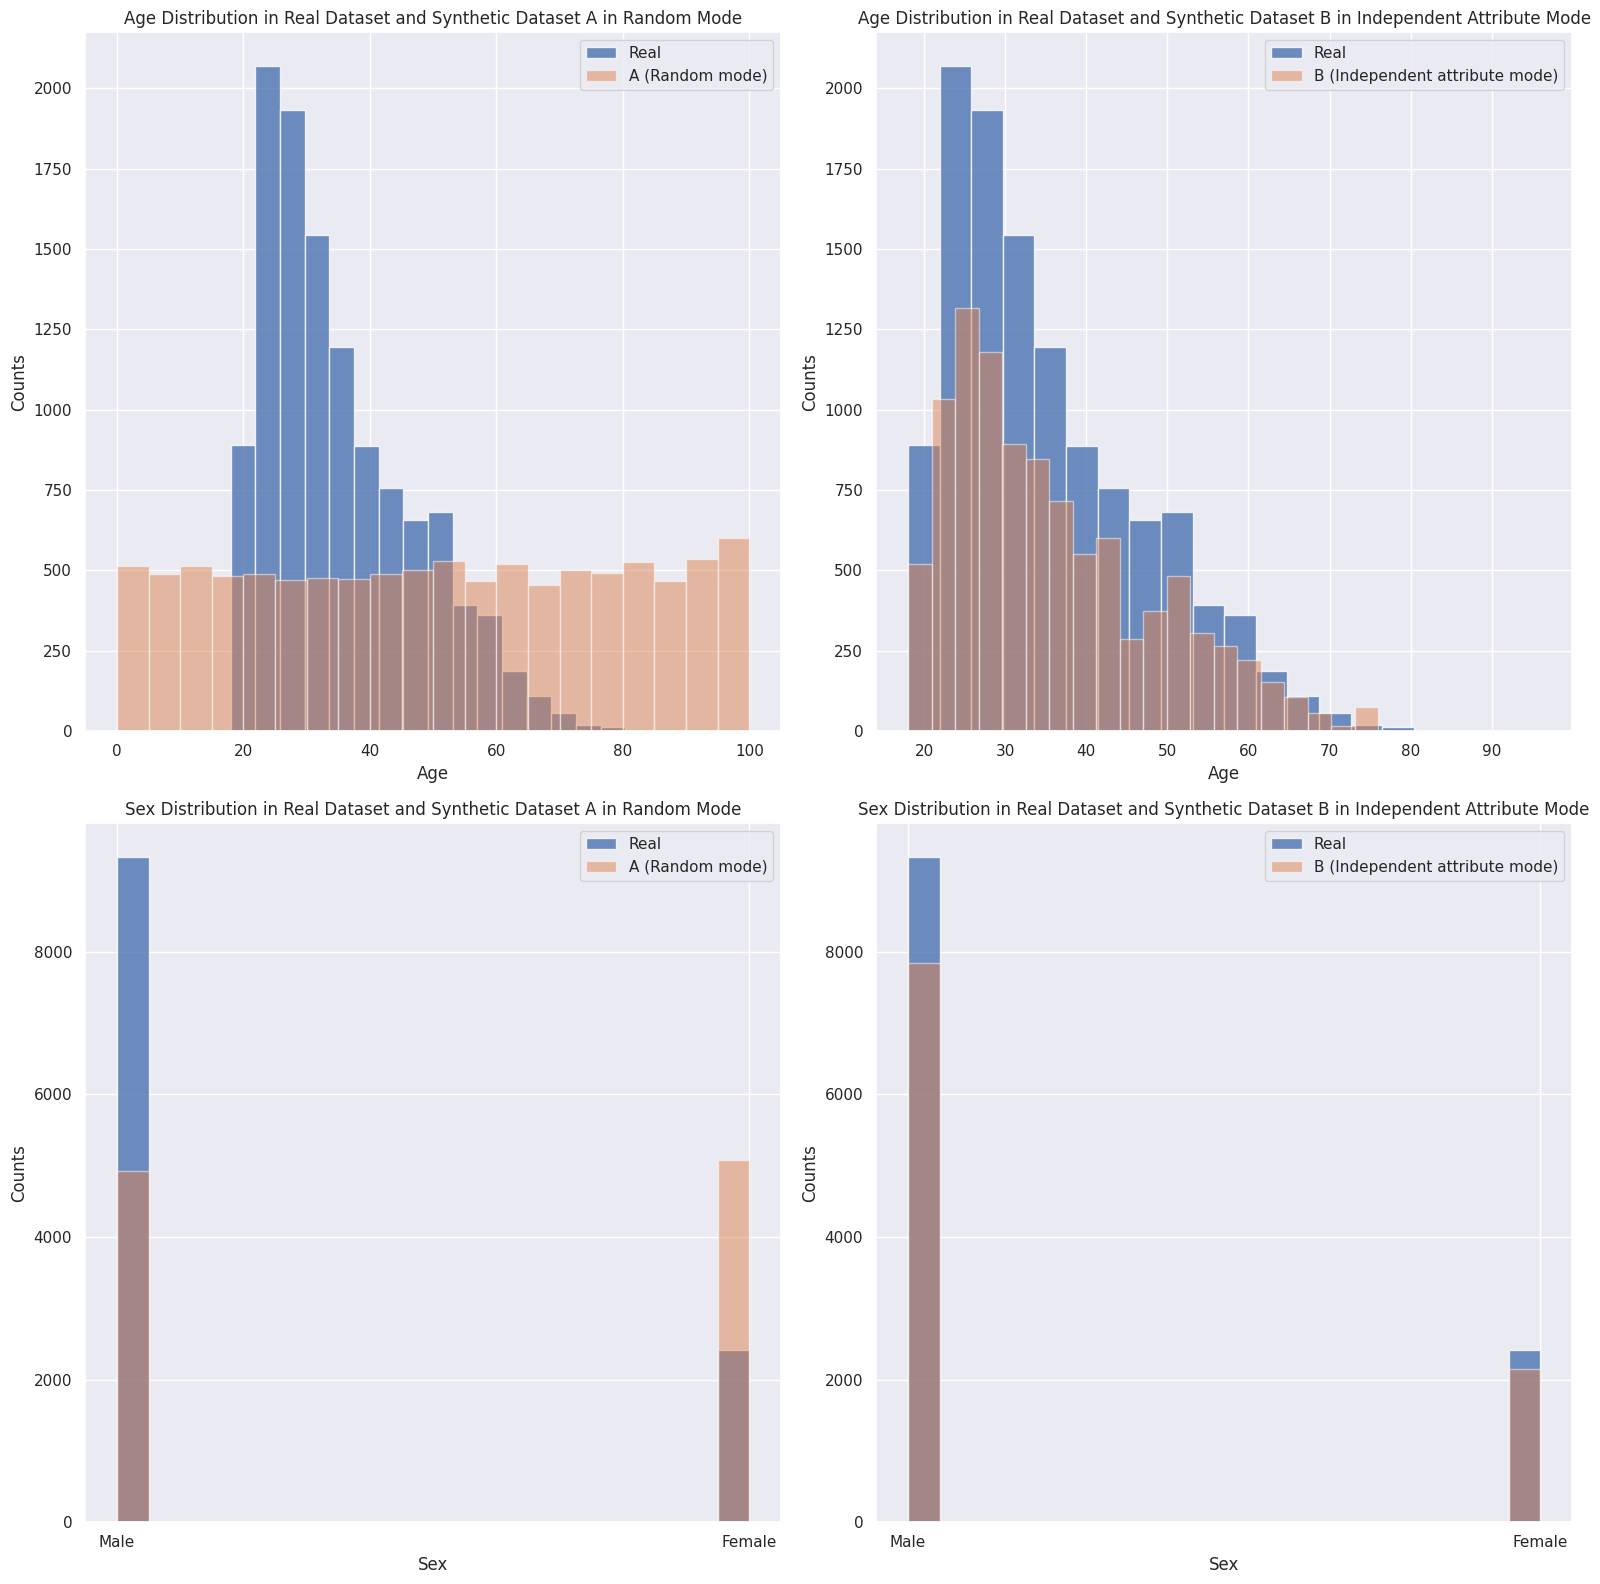

In [196]:
#ccompare how well A and B replicate the original distribution
#plot the values of age and sex in real data and A and B
#Using histograms, 4 plots in total


plt.figure(figsize=(16, 16))
#compare age in real and A
plt.subplot(2, 2, 1)
plt.hist(df_real['age'], bins=20, alpha=0.8, label='Real')
plt.hist(df_real_A['age'], bins=20, alpha=0.5, label='A (Random mode)')
plt.title('Age Distribution in Real Dataset and Synthetic Dataset A in Random Mode')
plt.xlabel('Age')
plt.ylabel('Counts')
plt.legend()

#compare age in real and B
plt.subplot(2, 2, 2)
plt.hist(df_real['age'], bins=20, alpha=0.8, label='Real')
plt.hist(df_real_B['age'], bins=20, alpha=0.5, label='B (Independent attribute mode)')
plt.title('Age Distribution in Real Dataset and Synthetic Dataset B in Independent Attribute Mode')
plt.xlabel('Age')
plt.ylabel('Counts')
plt.legend()

#compare sex attribute in real and A
plt.subplot(2, 2, 3)
plt.hist(df_real['sex'], bins=20, alpha=0.8, label='Real')
plt.hist(df_real_A['sex'], bins=20, alpha=0.5, label='A (Random mode)')
plt.title('Sex Distribution in Real Dataset and Synthetic Dataset A in Random Mode')
plt.xlabel('Sex')
plt.ylabel('Counts')
plt.legend()

#compare sex attribute in real and B
plt.subplot(2, 2, 4)
plt.hist(df_real['sex'], bins=20, alpha=0.8, label='Real')
plt.hist(df_real_B['sex'], bins=20, alpha=0.5, label='B (Independent attribute mode)')
plt.title('Sex Distribution in Real Dataset and Synthetic Dataset B in Independent Attribute Mode')
plt.xlabel('Sex')
plt.ylabel('Counts')
plt.legend()

plt.tight_layout()
plt.show()

#### Two-sample Kolmogorov–Smirnov test for continous attributes

In [11]:
def ks_test(df_in: pd.DataFrame, df_out: pd.DataFrame, attr: str):
    """
    df_in: the sensitive dataset
    df_out: the synthetic dataset
    attr: the attribute that will be calculated for Two-sample Kolmogorov–Smirnov test.
    """
    return ks_2samp(df_in[attr], df_out[attr])[0]

In [40]:
#ks_test for numerical attribute (age)
ks_test_A = ks_test(df_real, df_real_A, "age")
ks_test_B = ks_test(df_real, df_real_B, "age")
print(f"ks_test_A: {ks_test_A}")
print(f"ks_test_B: {ks_test_B}")

ks_test_A: 0.3735091775112699
ks_test_B: 0.026252445351705345


#### KL-divergence for categorical attributes

In [12]:
def get_distribution_of_categorical_attribute(attribute: pd.Series, indicies=None):
    distribution = attribute.dropna().value_counts()
    if indicies is not None:
        for idx in set(indicies) - set(distribution.index):
            distribution.loc[idx] = 0
    distribution.sort_index(inplace=True)
    return distribution/sum(distribution)

def kl_test(df_in: pd.DataFrame, df_out: pd.DataFrame, attr: str):
    """
    df_in: the sensitive dataset
    df_out: the synthetic dataset
    attr: the attribute that will be calculated for KL-divergence.
    """
    distribution_in = get_distribution_of_categorical_attribute(df_in[attr])
    distribution_out = get_distribution_of_categorical_attribute(df_out[attr], distribution_in.index)
    return entropy(distribution_out, distribution_in)

In [41]:
#kl_test for categorical attribute
kl_test_A = kl_test(df_real, df_real_A, "sex")
kl_test_B = kl_test(df_real, df_real_B, "sex")
print(f"kl_test_A: {kl_test_A}")
print(f"kl_test_B: {kl_test_B}")

kl_test_A: 0.22319792405369002
kl_test_B: 0.0002494300869420041


### Q3

some more sophisticated statistical measure that’s good for correlated attribute mode, and will be better with k=2 (case D) than with k=1 (case C), __some distance over pairwise correlation coefficients? Also show the difference visually, comparing results on real vs. synthetic datasets__.

In [48]:
print(df_real.columns)
print(df_fake.columns)

Index(['sex', 'age', 'race', 'score'], dtype='object')
Index(['parent_1', 'parent_2', 'child_1', 'child_2'], dtype='object')


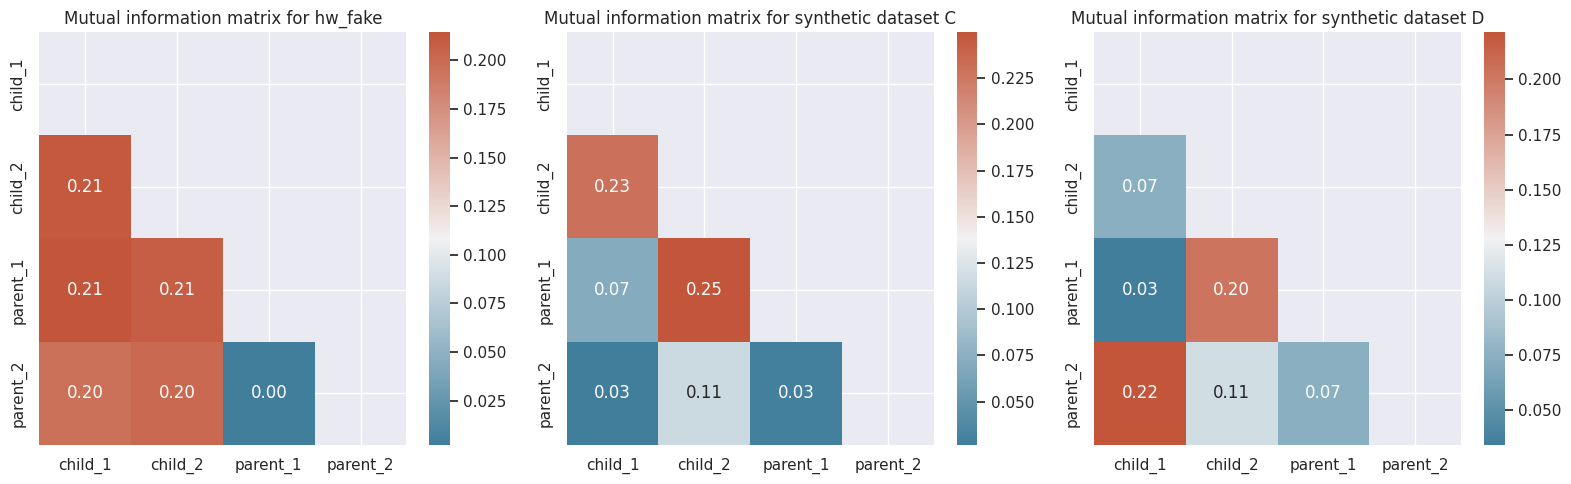

In [96]:
# Use pairwise_attributes_mutual_information function.
# For function parameters, refer to https://github.com/DataResponsibly/DataSynthesizer/blob/master/DataSynthesizer/lib/utils.py#L31
fig, axes = plt.subplots(1, 3, figsize=(16, 5))
cmap = sns.diverging_palette(230, 20, as_cmap=True)

matrix = pairwise_attributes_mutual_information(df_fake)
mask = np.triu(np.ones_like(matrix, dtype=bool))
sns.heatmap(matrix,mask = mask, cmap=cmap, annot=True, fmt='.2f',ax = axes[0])
axes[0].set_title("Mutual information matrix for hw_fake")

plt.subplot(1,3,2)
matrix_fakeC = pairwise_attributes_mutual_information(df_fake_C)
mask_C = np.triu(np.ones_like(matrix_fakeC, dtype=bool))
sns.heatmap (matrix_fakeC,mask = mask_C, cmap=cmap, annot=True, fmt='.2f',ax = axes[1])
axes[1].set_title("Mutual information matrix for synthetic dataset C")

plt.subplot(1,3,3)
matrix_fakeD = pairwise_attributes_mutual_information(df_fake_D)
mask_D = np.triu(np.ones_like(matrix_fakeD, dtype=bool))
sns.heatmap (matrix_fakeD,mask = mask_D, cmap=cmap, annot=True, fmt='.2f',ax = axes[2])
axes[2].set_title("Mutual information matrix for synthetic dataset D")
plt.tight_layout()
plt.show()

## Part (b)

Study the variability in accuracy of answers to Q1 and Q2 for A, B and C: fix epsilon = 0.1, generate __10__ synthetic databases (by specifying different seeds).  Plot accuracy as a box-and-whiskers plot.  

In [103]:
# You can use sns.boxplot for the plots
# For examples, refer to https://seaborn.pydata.org/generated/seaborn.boxplot.html
#epsilon = 0.1 are fixed in the data genereating function

#compare with the real data
real_stats = cal_statistics(df_real, 'age')
dataset_A = []
dataset_B = []
dataset_C = []
for seed in range(10):
  syn_A = generate_data_A(real_data_file, output_data_size,seed=seed)
  syn_B = generate_data_B(real_data_file, output_data_size,seed=seed)
  syn_C = generate_data_C(real_data_file, output_data_size,seed=seed)
  dataset_A.append(cal_statistics(syn_A, 'age'))
  dataset_B.append(cal_statistics(syn_B, 'age'))
  dataset_C.append(cal_statistics(syn_C, 'age'))

df_A = pd.DataFrame(dataset_A)
df_B = pd.DataFrame(dataset_B)
df_C = pd.DataFrame(dataset_C)


================ Constructing Bayesian Network (BN) ================
Adding ROOT sex
Adding attribute age
Adding attribute score
Adding attribute race
========================== BN constructed ==========================
================ Constructing Bayesian Network (BN) ================
Adding ROOT age
Adding attribute race
Adding attribute score
Adding attribute sex
========================== BN constructed ==========================
================ Constructing Bayesian Network (BN) ================
Adding ROOT sex
Adding attribute race
Adding attribute age
Adding attribute score
========================== BN constructed ==========================
================ Constructing Bayesian Network (BN) ================
Adding ROOT age
Adding attribute score
Adding attribute race
Adding attribute sex
========================== BN constructed ==========================
================ Constructing Bayesian Network (BN) ================
Adding ROOT age
Adding attribute score
Adding attri

In [119]:
print(df_A)
print(df_B)

   median     mean  min  max
0    50.0  49.9399    0  100
1    50.0  49.6333    0  100
2    50.0  50.1391    0  100
3    50.0  50.3169    0  100
4    50.0  50.3283    0  100
5    50.0  50.0036    0  100
6    50.0  50.0446    0  100
7    50.0  49.6582    0  100
8    52.0  50.8544    0  100
9    50.0  50.0983    0  100
   median     mean   min   max
0    33.0  36.0505  18.0  92.0
1    33.0  36.5687  18.0  88.0
2    33.0  36.7526  18.0  88.0
3    32.0  34.7590  18.0  88.0
4    31.0  34.4329  18.0  79.0
5    33.0  38.4721  18.0  96.0
6    32.0  36.1953  18.0  88.0
7    32.0  35.8525  18.0  88.0
8    32.0  35.3014  18.0  86.0
9    32.0  36.5194  18.0  96.0


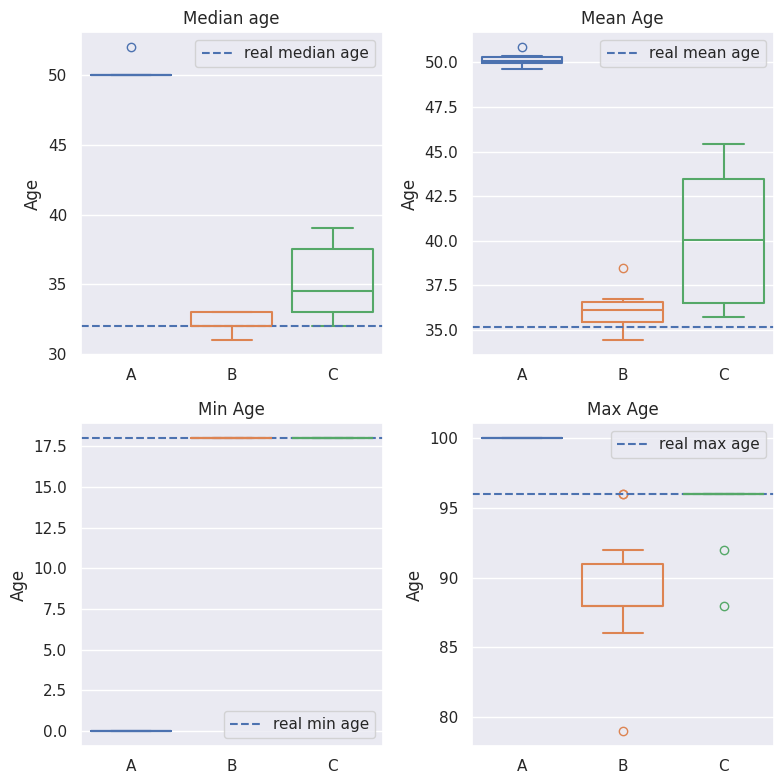

In [149]:

median_dataframe = pd.DataFrame({ 'A': df_A['median'], 'B': df_B['median'], 'C': df_C['median']})
mean_df = pd.DataFrame({ 'A': df_A['mean'], 'B': df_B['mean'], 'C': df_C['mean']})
min_df = pd.DataFrame({ 'A': df_A['min'], 'B': df_B['min'], 'C': df_C['min']})
max_df = pd.DataFrame({ 'A': df_A['max'], 'B': df_B['max'], 'C': df_C['max']})

fig, axs = plt.subplots(2,2, figsize=(8,8))

sns.boxplot(data=median_dataframe,ax = axs[0,0],fill = False)
axs[0,0].axhline(real_stats['median'], linestyle='--', label='real median age')
axs[0,0].set_title('Median age')
axs[0,0].set_ylabel('Age')
axs[0,0].legend()

sns.boxplot(data=mean_df,ax = axs[0,1],fill = False)
axs[0,1].axhline(real_stats['mean'], linestyle='--', label='real mean age')
axs[0,1].set_title('Mean Age')
axs[0,1].set_ylabel('Age')
axs[0,1].legend()

sns.boxplot(data=min_df,ax = axs[1,0],fill = False)
axs[1,0].axhline(real_stats['min'], linestyle='--', label='real min age')
axs[1,0].set_title('Min Age')
axs[1,0].set_ylabel('Age')
axs[1,0].legend()

sns.boxplot(data=max_df,ax = axs[1,1],fill = False)
axs[1,1].axhline(real_stats['max'], linestyle='--', label='real max age')
axs[1,1].set_title('Max Age')
axs[1,1].set_ylabel('Age')
axs[1,1].legend()

plt.tight_layout()
plt.show()

## Part (c)

Study how accuracy of Q3 changes for case **C**, as you vary __epsilon__ = [0.01, 0.02, ..., 0.1].

In [16]:
# Your code here

In [151]:
epsilons_mst_kl = [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1]
iters = 10
kl_diverg_B = {}
kl_diverg_C = {}
kl_diverg_D = {}
for epsilon in epsilons_mst_kl:
  kl_diverg_B[epsilon] = []
  kl_diverg_C[epsilon] = []
  kl_diverg_D[epsilon] = []
  for seed in range(iters):
    synthetic_b = generate_data_B(real_data_file, output_data_size,epsilon=epsilon,seed=seed)
    synthetic_c = generate_data_C(real_data_file, output_data_size,epsilon=epsilon,seed=seed)
    synthetic_d = generate_data_D(real_data_file, output_data_size,epsilon=epsilon,seed=seed)
    kl_diverg_B[epsilon].append(kl_test(df_real, synthetic_b,"race"))
    kl_diverg_C[epsilon].append(kl_test(df_real, synthetic_c,"race"))
    kl_diverg_D[epsilon].append(kl_test(df_real, synthetic_d,"race"))


================ Constructing Bayesian Network (BN) ================
Adding ROOT race
Adding attribute score
Adding attribute age
Adding attribute sex
========================== BN constructed ==========================
================ Constructing Bayesian Network (BN) ================
Adding ROOT sex
Adding attribute race
Adding attribute age
Adding attribute score
========================== BN constructed ==========================
================ Constructing Bayesian Network (BN) ================
Adding ROOT age
Adding attribute race
Adding attribute score
Adding attribute sex
========================== BN constructed ==========================
================ Constructing Bayesian Network (BN) ================
Adding ROOT age
Adding attribute race
Adding attribute score
Adding attribute sex
========================== BN constructed ==========================
================ Constructing Bayesian Network (BN) ================
Adding ROOT sex
Adding attribute race
Adding attrib

In [152]:
Kl_df_B = pd.DataFrame(kl_diverg_B) #kl_diverg_B include different seed + different epsilon
Kl_df_C = pd.DataFrame(kl_diverg_C)
Kl_df_D = pd.DataFrame(kl_diverg_D)

       0.01      0.02      0.03      0.04      0.05      0.06      0.07  \
0  0.056113  0.008876  0.008628  0.008051  0.006217  0.005782  0.005611   
1  0.037894  0.012875  0.010271  0.009418  0.009091  0.008909  0.008788   
2  0.022743  0.008696  0.006001  0.004917  0.004480  0.004161  0.003954   
3  0.011820  0.009266  0.008891  0.008661  0.008576  0.008567  0.008552   
4  0.110582  0.028984  0.017421  0.013701  0.012194  0.011164  0.010590   
5  0.267491  0.186327  0.064962  0.034723  0.022270  0.015880  0.014681   
6  0.147411  0.044002  0.021238  0.012060  0.008859  0.006367  0.003504   
7  0.112508  0.104753  0.103469  0.102803  0.059204  0.037465  0.025396   
8  0.193901  0.077970  0.042593  0.028109  0.019708  0.015010  0.011784   
9  0.120490  0.076628  0.070084  0.034062  0.020061  0.014726  0.011703   

       0.08      0.09      0.10  
0  0.005469  0.005470  0.003478  
1  0.008676  0.008641  0.008624  
2  0.003849  0.003767  0.003710  
3  0.008546  0.008525  0.008517  
4  0

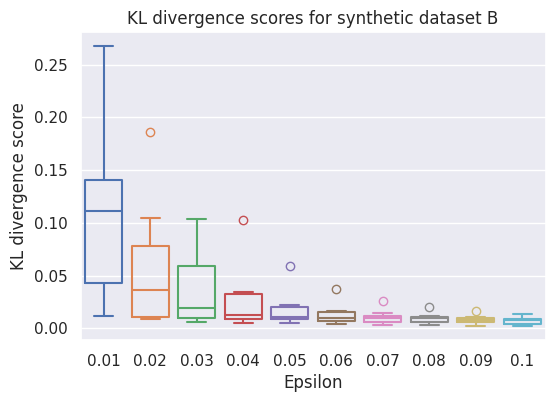

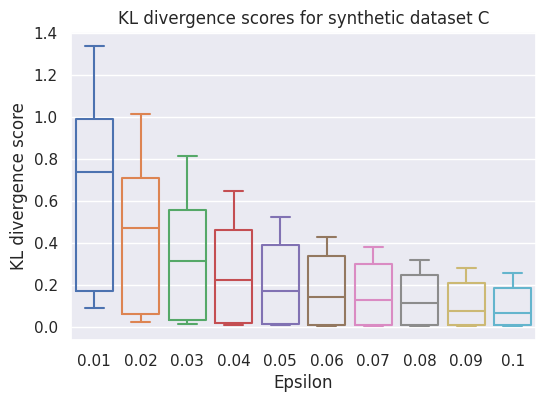

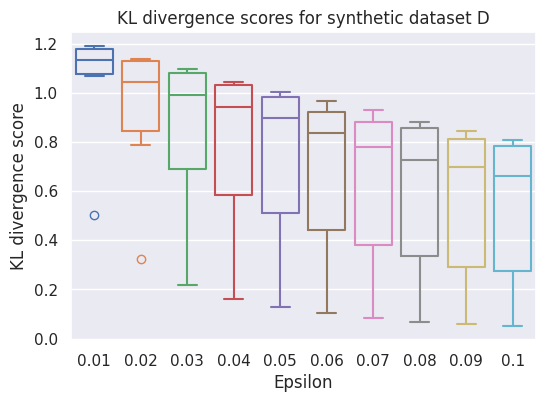

In [199]:
plt.figure(figsize=(6,4))
sns.boxplot(data=Kl_df_B,fill = False)
plt.title('KL divergence scores for synthetic dataset B')
plt.xlabel('Epsilon')
plt.ylabel('KL divergence score')
plt.show()

plt.figure(figsize=(6,4))
sns.boxplot(data=Kl_df_C,fill = False)
plt.title('KL divergence scores for synthetic dataset C')
plt.xlabel('Epsilon')
plt.ylabel('KL divergence score')
plt.show()

plt.figure(figsize=(6,4))
sns.boxplot(data=Kl_df_D,fill = False)
plt.title('KL divergence scores for synthetic dataset D')
plt.xlabel('Epsilon')
plt.ylabel('KL divergence score')
plt.show()



#### Mutual Information Plot for MST
Again, replicate your plots from Part (c) for MST, this time for mutual information, on both hw_compas and hw_fake (df_real and df_fake), varying epsilon = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]. Compare this plot to the plot of dataset **D** (df_real_D). Once again, you need only generate **5 datasets** per epsilon (i.e., run 5 iterations per epsilon).

In [175]:
import numpy as np

#define a function to aggregate the absolute difference
#input should be two matrix
def cal_sum_pairmi(syn_matrix,real_matrix):
  sum = 0
  real_mi = np.array(real_matrix)
  syn_mi = np.array(syn_matrix)
  upper_tri_idx = np.triu_indices_from(real_mi, k=1)
  sum = np.sum(np.abs(real_mi[upper_tri_idx] - syn_mi[upper_tri_idx]))
  return sum

#define a function to calculate the mutual information
epsilons_mst_mi = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
iters = 10
real_matrix = pairwise_attributes_mutual_information(df_real)
fake_matrix = pairwise_attributes_mutual_information(df_fake)

dif_real_B = {str(eps): [] for eps in epsilons_mst_mi}
dif_real_C = {str(eps): [] for eps in epsilons_mst_mi}
dif_real_D = {str(eps): [] for eps in epsilons_mst_mi}
dif_fake_B = {str(eps): [] for eps in epsilons_mst_mi}
dif_fake_C = {str(eps): [] for eps in epsilons_mst_mi}
dif_fake_D = {str(eps): [] for eps in epsilons_mst_mi}
for epsilon in epsilons_mst_mi:
  eps_str = str(epsilon)
  for i in range(iters):
    syn_real_B = generate_data_B(real_data_file, output_data_size, epsilon=epsilon, seed = i)
    syn_real_C = generate_data_C(real_data_file, output_data_size, epsilon=epsilon, seed = i)
    syn_real_D = generate_data_D(real_data_file, output_data_size, epsilon=epsilon)
    syn_fake_B = generate_data_B(fake_data_file, output_data_size, epsilon=epsilon)
    syn_fake_C = generate_data_C(fake_data_file, output_data_size, epsilon=epsilon)
    syn_fake_D= generate_data_D(fake_data_file, output_data_size, epsilon=epsilon)

    dif_real_b = cal_sum_pairmi(pairwise_attributes_mutual_information(syn_real_B),real_matrix)
    dif_real_c = cal_sum_pairmi(pairwise_attributes_mutual_information(syn_real_C),real_matrix)
    dif_real_d = cal_sum_pairmi(pairwise_attributes_mutual_information(syn_real_D),real_matrix)
    dif_fake_b = cal_sum_pairmi(pairwise_attributes_mutual_information(syn_fake_B),fake_matrix)
    dif_fake_c = cal_sum_pairmi(pairwise_attributes_mutual_information(syn_fake_C),fake_matrix)
    dif_fake_d = cal_sum_pairmi(pairwise_attributes_mutual_information(syn_fake_D),fake_matrix)

    dif_real_B[eps_str].append(dif_real_b)
    dif_real_C[eps_str].append(dif_real_c)
    dif_real_D[eps_str].append(dif_real_d)
    dif_fake_B[eps_str].append(dif_fake_b)
    dif_fake_C[eps_str].append(dif_fake_c)
    dif_fake_D[eps_str].append(dif_fake_d)












================ Constructing Bayesian Network (BN) ================
Adding ROOT sex
Adding attribute age
Adding attribute score
Adding attribute race
========================== BN constructed ==========================
================ Constructing Bayesian Network (BN) ================
Adding ROOT age
Adding attribute race
Adding attribute score
Adding attribute sex
========================== BN constructed ==========================
================ Constructing Bayesian Network (BN) ================
Adding ROOT parent_2
Adding attribute parent_1
Adding attribute child_2
Adding attribute child_1
========================== BN constructed ==========================
================ Constructing Bayesian Network (BN) ================
Adding ROOT child_1
Adding attribute parent_1
Adding attribute parent_2
Adding attribute child_2
========================== BN constructed ==========================
================ Constructing Bayesian Network (BN) ================
Adding ROOT age
Addin

/usr/local/lib/python3.10/dist-packages/DataSynthesizer/lib/PrivBayes.py:193: RuntimeWarning: overflow encountered in exp
  mi_array = np.exp(mi_array)


Adding attribute race
Adding attribute sex
========================== BN constructed ==========================
================ Constructing Bayesian Network (BN) ================
Adding ROOT score
Adding attribute age


/usr/local/lib/python3.10/dist-packages/DataSynthesizer/lib/PrivBayes.py:193: RuntimeWarning: overflow encountered in exp
  mi_array = np.exp(mi_array)


Adding attribute race
Adding attribute sex
========================== BN constructed ==========================
================ Constructing Bayesian Network (BN) ================
Adding ROOT child_1
Adding attribute parent_1
Adding attribute child_2
Adding attribute parent_2
========================== BN constructed ==========================
================ Constructing Bayesian Network (BN) ================
Adding ROOT child_1
Adding attribute parent_1
Adding attribute parent_2
Adding attribute child_2
========================== BN constructed ==========================
================ Constructing Bayesian Network (BN) ================
Adding ROOT age
Adding attribute score


/usr/local/lib/python3.10/dist-packages/DataSynthesizer/lib/PrivBayes.py:193: RuntimeWarning: overflow encountered in exp
  mi_array = np.exp(mi_array)


Adding attribute race
Adding attribute sex
========================== BN constructed ==========================
================ Constructing Bayesian Network (BN) ================
Adding ROOT age
Adding attribute score


/usr/local/lib/python3.10/dist-packages/DataSynthesizer/lib/PrivBayes.py:193: RuntimeWarning: overflow encountered in exp
  mi_array = np.exp(mi_array)


Adding attribute race
Adding attribute sex
========================== BN constructed ==========================
================ Constructing Bayesian Network (BN) ================
Adding ROOT child_1
Adding attribute child_2
Adding attribute parent_1
Adding attribute parent_2
========================== BN constructed ==========================
================ Constructing Bayesian Network (BN) ================
Adding ROOT child_1
Adding attribute parent_1
Adding attribute parent_2
Adding attribute child_2
========================== BN constructed ==========================
================ Constructing Bayesian Network (BN) ================
Adding ROOT sex
Adding attribute score
Adding attribute age


/usr/local/lib/python3.10/dist-packages/DataSynthesizer/lib/PrivBayes.py:193: RuntimeWarning: overflow encountered in exp
  mi_array = np.exp(mi_array)


Adding attribute race
========================== BN constructed ==========================
================ Constructing Bayesian Network (BN) ================
Adding ROOT score
Adding attribute age


/usr/local/lib/python3.10/dist-packages/DataSynthesizer/lib/PrivBayes.py:193: RuntimeWarning: overflow encountered in exp
  mi_array = np.exp(mi_array)


Adding attribute race
Adding attribute sex
========================== BN constructed ==========================
================ Constructing Bayesian Network (BN) ================
Adding ROOT parent_1
Adding attribute child_1
Adding attribute child_2
Adding attribute parent_2
========================== BN constructed ==========================
================ Constructing Bayesian Network (BN) ================
Adding ROOT child_2
Adding attribute parent_1
Adding attribute parent_2
Adding attribute child_1
========================== BN constructed ==========================
================ Constructing Bayesian Network (BN) ================
Adding ROOT age
Adding attribute score


/usr/local/lib/python3.10/dist-packages/DataSynthesizer/lib/PrivBayes.py:193: RuntimeWarning: overflow encountered in exp
  mi_array = np.exp(mi_array)


Adding attribute race
Adding attribute sex
========================== BN constructed ==========================
================ Constructing Bayesian Network (BN) ================
Adding ROOT race
Adding attribute score
Adding attribute age


/usr/local/lib/python3.10/dist-packages/DataSynthesizer/lib/PrivBayes.py:193: RuntimeWarning: overflow encountered in exp
  mi_array = np.exp(mi_array)


Adding attribute sex
========================== BN constructed ==========================
================ Constructing Bayesian Network (BN) ================
Adding ROOT parent_1
Adding attribute child_1
Adding attribute child_2
Adding attribute parent_2
========================== BN constructed ==========================
================ Constructing Bayesian Network (BN) ================
Adding ROOT parent_2
Adding attribute child_2
Adding attribute parent_1
Adding attribute child_1
========================== BN constructed ==========================
================ Constructing Bayesian Network (BN) ================
Adding ROOT age
Adding attribute score


/usr/local/lib/python3.10/dist-packages/DataSynthesizer/lib/PrivBayes.py:193: RuntimeWarning: overflow encountered in exp
  mi_array = np.exp(mi_array)


Adding attribute race
Adding attribute sex
========================== BN constructed ==========================
================ Constructing Bayesian Network (BN) ================
Adding ROOT age
Adding attribute score


/usr/local/lib/python3.10/dist-packages/DataSynthesizer/lib/PrivBayes.py:193: RuntimeWarning: overflow encountered in exp
  mi_array = np.exp(mi_array)


Adding attribute race
Adding attribute sex
========================== BN constructed ==========================
================ Constructing Bayesian Network (BN) ================
Adding ROOT parent_2
Adding attribute child_2
Adding attribute child_1
Adding attribute parent_1
========================== BN constructed ==========================
================ Constructing Bayesian Network (BN) ================
Adding ROOT parent_2
Adding attribute child_2
Adding attribute parent_1
Adding attribute child_1
========================== BN constructed ==========================
================ Constructing Bayesian Network (BN) ================
Adding ROOT race
Adding attribute score
Adding attribute age


/usr/local/lib/python3.10/dist-packages/DataSynthesizer/lib/PrivBayes.py:193: RuntimeWarning: overflow encountered in exp
  mi_array = np.exp(mi_array)


Adding attribute sex
========================== BN constructed ==========================
================ Constructing Bayesian Network (BN) ================
Adding ROOT sex
Adding attribute score
Adding attribute age


/usr/local/lib/python3.10/dist-packages/DataSynthesizer/lib/PrivBayes.py:193: RuntimeWarning: overflow encountered in exp
  mi_array = np.exp(mi_array)


Adding attribute race
========================== BN constructed ==========================
================ Constructing Bayesian Network (BN) ================
Adding ROOT parent_2
Adding attribute child_2
Adding attribute child_1
Adding attribute parent_1
========================== BN constructed ==========================
================ Constructing Bayesian Network (BN) ================
Adding ROOT parent_2
Adding attribute child_2
Adding attribute parent_1
Adding attribute child_1
========================== BN constructed ==========================
================ Constructing Bayesian Network (BN) ================
Adding ROOT sex
Adding attribute score
Adding attribute age


/usr/local/lib/python3.10/dist-packages/DataSynthesizer/lib/PrivBayes.py:193: RuntimeWarning: overflow encountered in exp
  mi_array = np.exp(mi_array)


Adding attribute race
========================== BN constructed ==========================
================ Constructing Bayesian Network (BN) ================
Adding ROOT score
Adding attribute age


/usr/local/lib/python3.10/dist-packages/DataSynthesizer/lib/PrivBayes.py:193: RuntimeWarning: overflow encountered in exp
  mi_array = np.exp(mi_array)


Adding attribute race
Adding attribute sex
========================== BN constructed ==========================
================ Constructing Bayesian Network (BN) ================
Adding ROOT parent_1
Adding attribute child_1
Adding attribute child_2
Adding attribute parent_2
========================== BN constructed ==========================
================ Constructing Bayesian Network (BN) ================
Adding ROOT child_1
Adding attribute parent_1
Adding attribute parent_2
Adding attribute child_2
========================== BN constructed ==========================
================ Constructing Bayesian Network (BN) ================
Adding ROOT race
Adding attribute score
Adding attribute age


/usr/local/lib/python3.10/dist-packages/DataSynthesizer/lib/PrivBayes.py:193: RuntimeWarning: overflow encountered in exp
  mi_array = np.exp(mi_array)


Adding attribute sex
========================== BN constructed ==========================
================ Constructing Bayesian Network (BN) ================
Adding ROOT race
Adding attribute score
Adding attribute age


/usr/local/lib/python3.10/dist-packages/DataSynthesizer/lib/PrivBayes.py:193: RuntimeWarning: overflow encountered in exp
  mi_array = np.exp(mi_array)


Adding attribute sex
========================== BN constructed ==========================
================ Constructing Bayesian Network (BN) ================
Adding ROOT parent_2
Adding attribute child_2
Adding attribute child_1
Adding attribute parent_1
========================== BN constructed ==========================
================ Constructing Bayesian Network (BN) ================
Adding ROOT parent_2
Adding attribute child_2
Adding attribute parent_1
Adding attribute child_1
========================== BN constructed ==========================
================ Constructing Bayesian Network (BN) ================
Adding ROOT age
Adding attribute score


/usr/local/lib/python3.10/dist-packages/DataSynthesizer/lib/PrivBayes.py:193: RuntimeWarning: overflow encountered in exp
  mi_array = np.exp(mi_array)


Adding attribute race
Adding attribute sex
========================== BN constructed ==========================
================ Constructing Bayesian Network (BN) ================
Adding ROOT age
Adding attribute score


/usr/local/lib/python3.10/dist-packages/DataSynthesizer/lib/PrivBayes.py:193: RuntimeWarning: overflow encountered in exp
  mi_array = np.exp(mi_array)


Adding attribute race
Adding attribute sex
========================== BN constructed ==========================
================ Constructing Bayesian Network (BN) ================
Adding ROOT child_2
Adding attribute child_1
Adding attribute parent_1
Adding attribute parent_2
========================== BN constructed ==========================
================ Constructing Bayesian Network (BN) ================
Adding ROOT child_2
Adding attribute child_1
Adding attribute parent_1
Adding attribute parent_2
========================== BN constructed ==========================
================ Constructing Bayesian Network (BN) ================
Adding ROOT score
Adding attribute age


/usr/local/lib/python3.10/dist-packages/DataSynthesizer/lib/PrivBayes.py:193: RuntimeWarning: overflow encountered in exp
  mi_array = np.exp(mi_array)


Adding attribute race
Adding attribute sex
========================== BN constructed ==========================
================ Constructing Bayesian Network (BN) ================
Adding ROOT age
Adding attribute score


/usr/local/lib/python3.10/dist-packages/DataSynthesizer/lib/PrivBayes.py:193: RuntimeWarning: overflow encountered in exp
  mi_array = np.exp(mi_array)


Adding attribute race
Adding attribute sex
========================== BN constructed ==========================
================ Constructing Bayesian Network (BN) ================
Adding ROOT parent_2
Adding attribute child_2
Adding attribute child_1
Adding attribute parent_1
========================== BN constructed ==========================
================ Constructing Bayesian Network (BN) ================
Adding ROOT parent_2
Adding attribute child_2
Adding attribute parent_1
Adding attribute child_1
========================== BN constructed ==========================


In [180]:
ddif_real_B = pd.DataFrame(dif_real_B)
ddif_real_C = pd.DataFrame(dif_real_C)
ddif_real_D = pd.DataFrame(dif_real_D)
ddif_fake_B = pd.DataFrame(dif_fake_B)
ddif_fake_C = pd.DataFrame(dif_fake_C)
ddif_fake_D = pd.DataFrame(dif_fake_D)

,0.0001,0.001,0.01,0.1,1,10,100
0,0.109051,0.106535,0.100287,0.095622,0.094628,0.094156,0.094158
1,0.110101,0.109910,0.102580,0.097741,0.095474,0.094983,0.094743
2,0.107139,0.103221,0.099857,0.094407,0.095902,0.095389,0.095400
3,0.110302,0.109182,0.099890,0.097837,0.094474,0.094884,0.094901
4,0.109643,0.110456,0.103566,0.099506,0.096065,0.096245,0.096204
5,0.102262,0.104989,0.102632,0.096342,0.094858,0.095272,0.095450
6,0.109330,0.106389,0.098476,0.095213,0.095552,0.096108,0.096144
7,0.108735,0.108269,0.098806,0.097219,0.094794,0.095447,0.095091
8,0.108531,0.106698,0.101690,0.095690,0.095728,0.095074,0.095112
9,0.110403,0.109484,0.097245,0.094685,0.094083,0.095260,0.095241


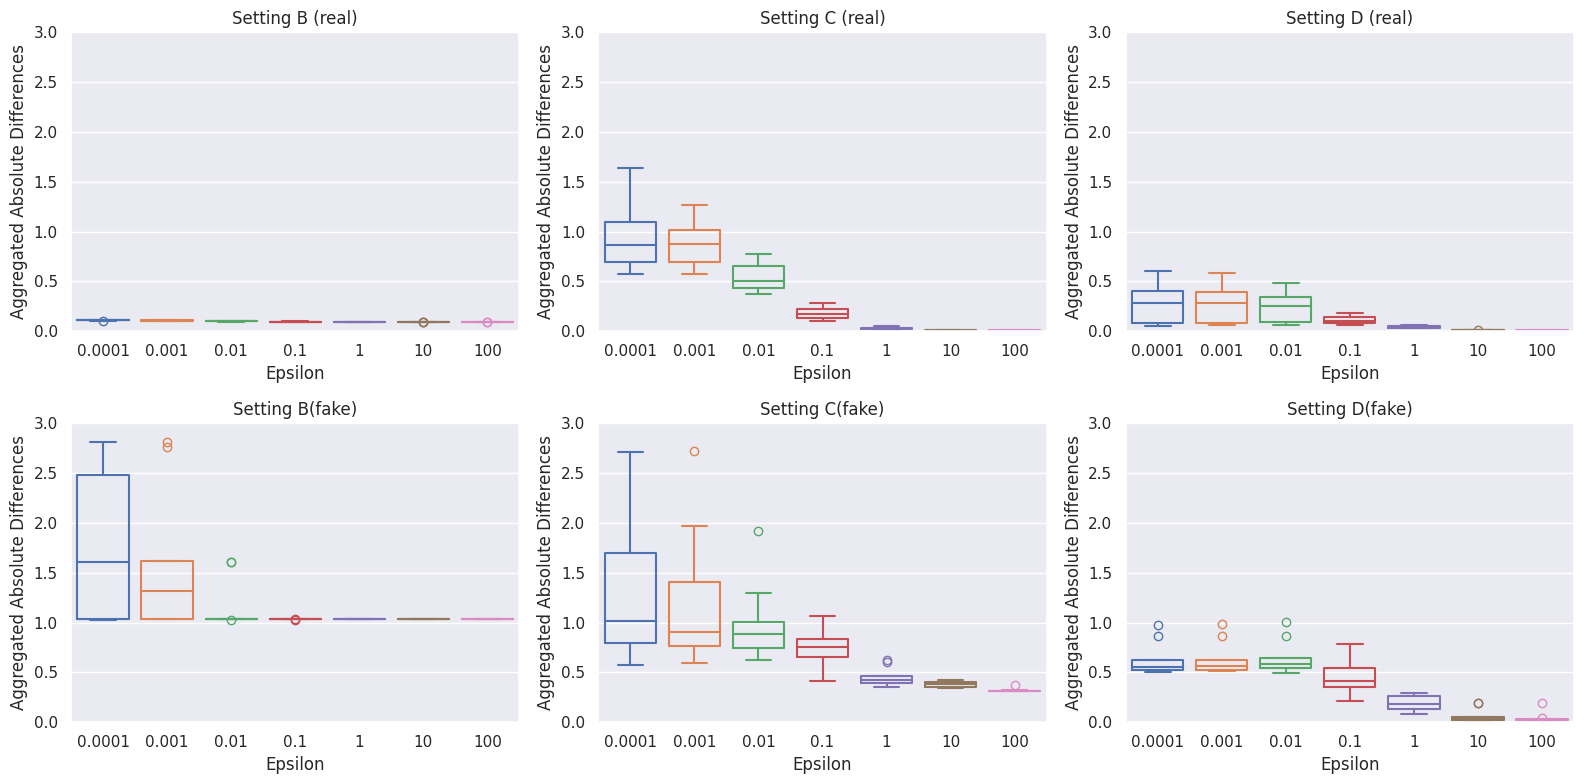

In [200]:
plt.figure(figsize=(16, 8))
#seting ylim[0,3]
# Real dataset
plt.subplot(2, 3, 1)
sns.boxplot(data=ddif_real_B, fill=False)
plt.title('Setting B (real)')
plt.xlabel('Epsilon')
plt.ylabel('Aggregated Absolute Differences')
plt.ylim(0,3)

plt.subplot(2, 3, 2)
sns.boxplot(data=ddif_real_C, fill=False)
plt.title('Setting C (real)')
plt.xlabel('Epsilon')
plt.ylabel('Aggregated Absolute Differences')
plt.ylim(0,3)

plt.subplot(2, 3, 3)
sns.boxplot(data=ddif_real_D, fill=False)
plt.title('Setting D (real)')
plt.xlabel('Epsilon')
plt.ylabel('Aggregated Absolute Differences')
plt.ylim(0,3)

# Fake dataset
plt.subplot(2, 3, 4)
sns.boxplot(data=ddif_fake_B, fill=False)
plt.title('Setting B(fake)')
plt.xlabel('Epsilon')
plt.ylabel('Aggregated Absolute Differences')
plt.ylim(0,3)

plt.subplot(2, 3, 5)
sns.boxplot(data=ddif_fake_C, fill=False)
plt.title('Setting C(fake)')
plt.xlabel('Epsilon')
plt.ylabel('Aggregated Absolute Differences')
plt.ylim(0,3)

plt.subplot(2, 3, 6)
sns.boxplot(data=ddif_fake_D, fill=False)
plt.title('Setting D(fake)')
plt.xlabel('Epsilon')
plt.ylabel('Aggregated Absolute Differences')
plt.ylim(0,3)

plt.tight_layout()
plt.show()
